# Import

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

sns.set_style("whitegrid")

Change directory to get source code:

In [2]:
main_path = os.getcwd()
parent_path = Path(os.getcwd()).parent
src_path = str(parent_path) + "/src/data"
os.chdir(src_path)

More import:

In [3]:
import change_directory

Change back to notebook directory:

In [4]:
os.chdir(main_path)

# ETL

## Load data

Change directory to get data:

In [5]:
cd = change_directory.ChangeDirectory()
cd.change_to_data_dir()

Load data:

In [6]:
properties = pd.read_csv("DC_Properties.csv")

/home/nt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (18,19,20,21,22,23,24,33,34,35,37,43,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Change back to notebook directory:

In [7]:
cd.change_to_notebook_dir()

## Explore data

Quick peek into the data:

In [8]:
properties.head()

,Unnamed: 0,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,...,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT
0,0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,...,-77.040832,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
1,1,3,1,Warm Cool,Y,2.0,11,5,1898.0,2007.0,...,-77.040764,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
2,2,3,1,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,...,-77.040678,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
3,3,3,1,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,...,-77.040629,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
4,4,2,1,Warm Cool,Y,1.0,11,3,1913.0,2012.0,...,-77.039361,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW


In [9]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158957 entries, 0 to 158956
Data columns (total 49 columns):
Unnamed: 0            158957 non-null int64
BATHRM                158957 non-null int64
HF_BATHRM             158957 non-null int64
HEAT                  158957 non-null object
AC                    158957 non-null object
NUM_UNITS             106696 non-null float64
ROOMS                 158957 non-null int64
BEDRM                 158957 non-null int64
AYB                   158686 non-null float64
YR_RMDL               80928 non-null float64
EYB                   158957 non-null int64
STORIES               106652 non-null float64
SALEDATE              132187 non-null object
PRICE                 98216 non-null float64
QUALIFIED             158957 non-null object
SALE_NUM              158957 non-null int64
GBA                   106696 non-null float64
BLDG_NUM              158957 non-null int64
STYLE                 106696 non-null object
STRUCT                106696 non-null 

Quite a few features with missing data.

Duplicates?

In [10]:
sum(properties.duplicated())

0

Good.

### Unnamed: 0

In [11]:
properties["Unnamed: 0"].nunique()

158957

In [12]:
properties["Unnamed: 0"].head()

0    0
1    1
2    2
3    3
4    4
Name: Unnamed: 0, dtype: int64

In [13]:
properties["Unnamed: 0"].tail()

158952    158952
158953    158953
158954    158954
158955    158955
158956    158956
Name: Unnamed: 0, dtype: int64

In [14]:
properties.drop("Unnamed: 0", axis=1, inplace=True)

### PRICE
Price of most recent sale.<br>This is our target variable for our linear regression models.

In [15]:
sum(properties.PRICE.isna())

60741

In [16]:
print(str(round(sum(properties.PRICE.isna()) / len(properties) * 100, 2)) + "% of our data is missing price values.")

38.21% of our data is missing price values.


Since our target variable is PRICE, we have no choice but to eliminate those rows with missing data.

In [17]:
properties = properties[~properties.PRICE.isna()]

Double check:

In [18]:
properties.shape

(98216, 48)

PRICE's distribution:

In [19]:
properties.PRICE.describe()

count    9.821600e+04
mean     9.313516e+05
std      7.061325e+06
min      1.000000e+00
25%      2.400000e+05
50%      3.999990e+05
75%      6.520000e+05
max      1.374275e+08
Name: PRICE, dtype: float64

Text(0.5, 1.0, 'PRICE Box Plot')

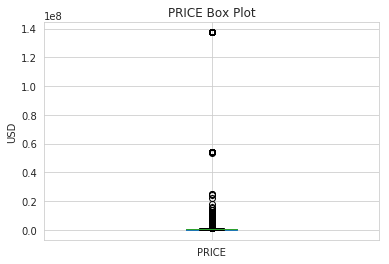

In [20]:
properties.PRICE.plot.box()
plt.ylabel("USD")
plt.title("PRICE Box Plot")

The cluster at 140 mil doesn't look right. The cluster at 60 mil doesn't look right either.<br> https://www.cnbc.com/2018/05/30/photos-of-the-most-expensive-home-for-sale-in-the-washington-dc-area.html

First cluster:

In [21]:
len(properties[properties.PRICE > 60000000])

242

In [22]:
properties[properties.PRICE > 60000000].PRICE.head()

125662    137427545.0
125663    137427545.0
125664    137427545.0
125670    137427545.0
125845    137427545.0
Name: PRICE, dtype: float64

In [23]:
sum(properties[properties.PRICE > 60000000].PRICE == 137427545)

242

Second cluster:

In [24]:
len(properties[(properties.PRICE > 50000000) & (properties.PRICE < 60000000)])

119

In [25]:
properties[(properties.PRICE > 50000000) & (properties.PRICE < 60000000)].PRICE.head()

132018    53969391.0
132019    53969391.0
132020    53969391.0
132021    53969391.0
132023    53969391.0
Name: PRICE, dtype: float64

In [26]:
sum(properties[(properties.PRICE > 50000000) & (properties.PRICE < 60000000)].PRICE == 53969391)

118

In [27]:
properties[(properties.PRICE > 50000000) & (properties.PRICE < 60000000)].loc[properties.PRICE != 53969391].PRICE

132028    53696391.0
Name: PRICE, dtype: float64

53,**969**,391 vs. 53,**696**,391..

It makes sense to get rid of these rows.

In [28]:
properties = properties[properties.PRICE < 50000000]
properties.shape

(97855, 48)

How cheap can DC houses go?<br>
Redfin shows a condo or two being sold under 50k. However, most of those "houses" being sold "for cheap" are garages. To be safe, we have decided to get rid of rows whose prices are less than 100k.

In [29]:
len(properties[properties.PRICE < 100000])

5681

In [30]:
properties = properties[properties.PRICE >= 100000]
properties.shape

(92174, 48)

PRICE's distribution:

In [31]:
properties.reset_index(inplace=True, drop=True)

Text(0.5, 1.0, 'PRICE Box Plot')

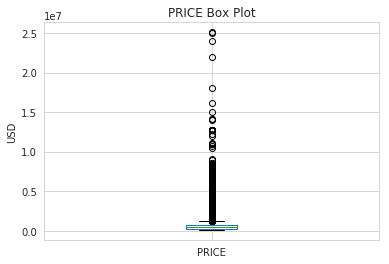

In [32]:
properties.PRICE.plot.box()
plt.ylabel("USD")
plt.title("PRICE Box Plot")

Text(0.5, 1.0, 'PRICE Histogram')

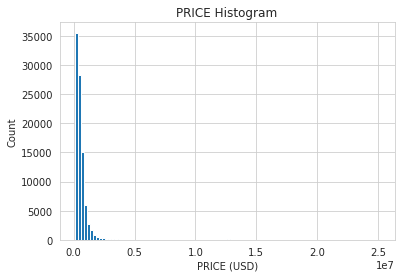

In [33]:
properties.PRICE.hist(bins=100)
plt.ylabel("Count")
plt.xlabel("PRICE (USD)")
plt.title("PRICE Histogram")

Would log be better?

In [34]:
properties["log(PRICE)"] = properties.PRICE.apply(lambda x: np.log(x))

Text(0.5, 1.0, 'log(PRICE) Histogram')

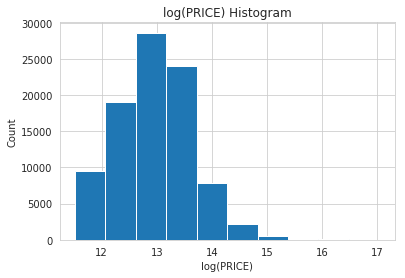

In [35]:
properties["log(PRICE)"].hist()
plt.ylabel("Count")
plt.xlabel("log(PRICE)")
plt.title("log(PRICE) Histogram")

Nice!

### BATHRM

In [36]:
sum(properties.BATHRM.isna())

0

In [37]:
properties.BATHRM.describe()

count    92174.000000
mean         1.895762
std          0.983556
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         12.000000
Name: BATHRM, dtype: float64

In [38]:
properties.BATHRM.value_counts()

1     38469
2     33090
3     14257
4      5028
5       863
6       308
7        81
8        33
0        23
9        11
10        7
11        3
12        1
Name: BATHRM, dtype: int64

It doesn't make sense to not have a bathroom.

In [39]:
properties = properties[properties.BATHRM > 0]
properties.reset_index(inplace=True, drop=True)

### HF_BATHRM

In [40]:
sum(properties.HF_BATHRM.isna())

0

In [41]:
properties.HF_BATHRM.describe()

count    92151.000000
mean         0.462263
std          0.581077
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         11.000000
Name: HF_BATHRM, dtype: float64

In [42]:
properties.HF_BATHRM.value_counts()

0     53315
1     35313
2      3340
3       147
4        26
5         7
7         2
11        1
Name: HF_BATHRM, dtype: int64

### HEAT

In [43]:
sum(properties.HEAT.isna())

0

In [44]:
properties.HEAT.describe()

count          92151
unique            14
top       Forced Air
freq           37288
Name: HEAT, dtype: object

In [45]:
properties.HEAT.value_counts()

Forced Air        37288
Hot Water Rad     21022
Warm Cool         16456
Ht Pump           15859
Wall Furnace        619
Water Base Brd      238
Elec Base Brd       236
No Data             172
Electric Rad         89
Air-Oil              61
Gravity Furnac       42
Ind Unit             32
Evp Cool             19
Air Exchng           18
Name: HEAT, dtype: int64

It makes sense to get rid of No Data rows.

In [46]:
properties = properties[properties.HEAT != "No Data"]
properties.reset_index(inplace=True, drop=True)

Dummy:

In [47]:
heat_dummies = pd.get_dummies(properties.HEAT, prefix="HEAT", drop_first=True)
properties = pd.concat([properties, heat_dummies], axis=1)
properties.drop("HEAT", axis=1, inplace=True)

### AC

In [48]:
sum(properties.AC.isna())

0

In [49]:
properties.AC.describe()

count     91979
unique        3
top           Y
freq      75780
Name: AC, dtype: object

In [50]:
properties.AC.value_counts()

Y    75780
N    16177
0       22
Name: AC, dtype: int64

It makes sense to get rid of 0 rows.

In [51]:
properties = properties[properties.AC != "0"]
properties.reset_index(inplace=True, drop=True)

In [52]:
properties.shape

(91957, 60)

Dummy:

In [53]:
ac_dummies = pd.get_dummies(properties.AC, prefix="AC", drop_first=True)
properties = pd.concat([properties, ac_dummies], axis=1)
properties.drop("AC", axis=1, inplace=True)

### NUM_UNITS

In [54]:
sum(properties.NUM_UNITS.isna())

37260

In [55]:
properties.NUM_UNITS.describe()

count    54697.000000
mean         1.218586
std          0.617154
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: NUM_UNITS, dtype: float64

In [56]:
properties.NUM_UNITS.value_counts()

1.0    46624
2.0     5768
4.0     1694
3.0      558
0.0       45
5.0        5
6.0        3
Name: NUM_UNITS, dtype: int64

**not sure what to do with this yet**

### ROOMS

In [57]:
sum(properties.ROOMS.isna())

0

In [58]:
properties.ROOMS.describe()

count    91957.000000
mean         5.981165
std          2.639198
min          0.000000
25%          4.000000
50%          6.000000
75%          7.000000
max         31.000000
Name: ROOMS, dtype: float64

In [59]:
properties.ROOMS.value_counts()

6     18640
4     14733
3     12666
7     11269
5      9776
8      8947
9      4097
10     3529
2      3360
12     1689
11     1321
16      731
13      417
14      305
15      166
20       75
18       65
1        57
17       34
0        33
19       16
21        8
24        6
23        5
22        4
25        3
28        2
30        1
26        1
31        1
Name: ROOMS, dtype: int64

It doesn't make sense to not have a room.

In [60]:
properties = properties[properties.ROOMS > 0]
properties.reset_index(inplace=True, drop=True)

### BEDRM

In [61]:
sum(properties.BEDRM.isna())

0

In [62]:
properties.BEDRM.describe()

count    91924.000000
mean         2.643314
std          1.393395
min          0.000000
25%          2.000000
50%          3.000000
75%          3.000000
max         20.000000
Name: BEDRM, dtype: float64

In [63]:
properties.BEDRM.value_counts()

3     28488
2     21882
1     17046
4     14251
5      4224
0      3225
6      1828
7       444
8       432
9        52
10       22
12       18
11        8
15        1
13        1
14        1
20        1
Name: BEDRM, dtype: int64

Studios technically don't have a bedroom.

### AYB
The earliest time the main portion of the building was built.

In [64]:
sum(properties.AYB.isna())

97

In [65]:
properties.AYB.describe()

count    91827.000000
mean      1944.934006
std         36.833573
min       1754.000000
25%       1917.000000
50%       1938.000000
75%       1967.000000
max       2018.000000
Name: AYB, dtype: float64

It doesn't hurt to get rid of the rows with missing data.

In [66]:
properties = properties[~properties.AYB.isna()]
properties.reset_index(inplace=True, drop=True)

### YR_RMDL
Year structure was remodeled.

In [67]:
sum(properties.YR_RMDL.isna())

37377

In [68]:
properties.YR_RMDL.describe()

count    54450.000000
mean      2001.136309
std         16.131212
min         20.000000
25%       1993.000000
50%       2006.000000
75%       2011.000000
max       2019.000000
Name: YR_RMDL, dtype: float64

1754 was the earliest time when the main portion of the oldest building was built.

In [69]:
properties[properties.YR_RMDL < 1754]

,BATHRM,HF_BATHRM,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,...,HEAT_Evp Cool,HEAT_Forced Air,HEAT_Gravity Furnac,HEAT_Hot Water Rad,HEAT_Ht Pump,HEAT_Ind Unit,HEAT_Wall Furnace,HEAT_Warm Cool,HEAT_Water Base Brd,AC_Y
31050,1,1,1.0,8,4,1929.0,20.0,1967,2.0,2015-08-06 00:00:00,...,0,1,0,0,0,0,0,0,0,1


It makes sense to get rid of this row.

In [70]:
properties = properties[~(properties.YR_RMDL < 1754)]
properties.reset_index(inplace=True, drop=True)

**not sure what to do with this yet**

### EYB
The year an improvement was built more recent than actual year built.

In [71]:
sum(properties.EYB.isna())

0

In [72]:
properties.EYB.describe()

count    91826.000000
mean      1966.416810
std         27.765082
min       1800.000000
25%       1954.000000
50%       1967.000000
75%       1982.000000
max       2018.000000
Name: EYB, dtype: float64

### STORIES
Number of stories in primary dwelling.

In [73]:
sum(properties.STORIES.isna())

37263

In [74]:
properties.STORIES.describe()

count    54563.000000
mean         2.132692
std          4.064968
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max        826.000000
Name: STORIES, dtype: float64

No way a buidling has 826 stories.

In [75]:
properties[properties.STORIES > 20].STORIES

4314     826.0
11895    250.0
12268    275.0
12712    275.0
18373     25.0
24860     25.0
42386     25.0
42398     25.0
Name: STORIES, dtype: float64

It makes sense to get rid of the rows whose stories are greater than 25.

In [76]:
properties = properties[~(properties.STORIES > 25)]
properties.reset_index(inplace=True, drop=True)

**not sure what to do with this yet**

### SALEDATE
Date of most recent sale.

In [77]:
sum(properties.SALEDATE.isna())

0

In [78]:
properties.SALEDATE.describe()

count                   91822
unique                   6405
top       2010-05-04 00:00:00
freq                      134
Name: SALEDATE, dtype: object

In [79]:
properties.SALEDATE.head()

0    2003-11-25 00:00:00
1    2016-06-21 00:00:00
2    2006-07-12 00:00:00
3    2010-02-26 00:00:00
4    2011-09-29 00:00:00
Name: SALEDATE, dtype: object

In [80]:
properties.SALEDATE = pd.to_datetime(properties.SALEDATE, format="%Y/%m/%d")

In [81]:
properties.SALEDATE.head()

0   2003-11-25
1   2016-06-21
2   2006-07-12
3   2010-02-26
4   2011-09-29
Name: SALEDATE, dtype: datetime64[ns]

### QUALIFIED

In [82]:
sum(properties.QUALIFIED.isna())

0

In [83]:
properties.QUALIFIED.describe()

count     91822
unique        2
top           Q
freq      73241
Name: QUALIFIED, dtype: object

In [84]:
properties.QUALIFIED.value_counts()

Q    73241
U    18581
Name: QUALIFIED, dtype: int64

Dummy:

In [85]:
qualified_dummies = pd.get_dummies(properties.QUALIFIED, prefix="QUALIFIED", drop_first=True)
properties = pd.concat([properties, qualified_dummies], axis=1)
properties.drop("QUALIFIED", axis=1, inplace=True)

### SALE_NUM

In [86]:
sum(properties.SALE_NUM.isna())

0

In [87]:
properties.SALE_NUM.describe()

count    91822.000000
mean         1.900481
std          1.418576
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         15.000000
Name: SALE_NUM, dtype: float64

In [88]:
properties.SALE_NUM.value_counts()

1     57726
3     11249
2      9093
4      7745
5      3617
6      1537
7       522
8       194
9        87
10       27
11       12
12        6
13        3
15        2
14        2
Name: SALE_NUM, dtype: int64

### GBA
Gross building area in square feet.

In [89]:
sum(properties.GBA.isna())

37231

In [90]:
properties.GBA.describe()

count    54591.000000
mean      1747.588650
std        831.869476
min        252.000000
25%       1228.000000
50%       1522.000000
75%       2012.500000
max      15902.000000
Name: GBA, dtype: float64

**not sure what to do with this yet**

### BLDG_NUM
Building Number on Property.

In [91]:
# sns.heatmap(properties, center=0)

In [92]:
# sns.pairplot(properties)

scaling???? logging???? normality????
for numerical variables (anything that's not dummy)